11493376/11490434 [==============================] - 0s 0us/step


Text(0.5, 1.0, '5')

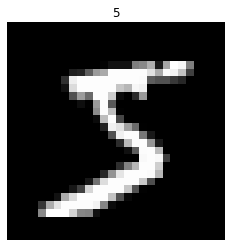

In [4]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo.utils.filter_design import cont2discrete
import numpy as np
import tensorflow as tf

import nengo_dl

# set seed
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

#load mnist dataset
(train_images, train_labels), (test_images, test_labels) = (tf.keras.datasets.mnist.load_data())

# normalize inputs to range from 0 to 1
train_images = train_images / 255
test_images = test_images / 255

# reshape the labels to rank 3 (as expected in Nengo)
train_labels = train_labels[:, None, None]
test_labels = test_labels[:, None, None]

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap = 'gray')
plt.axis('off')
plt.title(str(train_labels[0,0,0]))

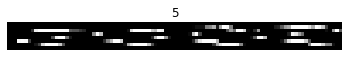

In [5]:
#goal of this network is to classify sequences

# this flattens the image into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# goes from (60000, 28, 28) to (60000, 784, 1)

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis('off')
plt.title(str(train_labels[0, 0, 0]));


In [6]:
# Defining the LMU cell 

class LMUCell(nengo.Network):
  def __init__(self, units, order, theta, input_d, **kwargs):
    super().__init__(**kwargs)

    #compute the A and B matrices according to the LMU math. derivation (in the paper)
    Q = np.arange(order, dtype=np.float64)
    R = (2 * Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)

    A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R 
    B = (-1.0) ** Q[:, None] * R 
    C = np.ones((1, order))
    D = np.zeros((1,))

    A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method = "zoh")

    with self:
      nengo_dl.configure_settings(trainable=None)

      # create objects corresponding to the x/u/m/h variables in the above diagram
      self.x = nengo.Node(size_in = input_d)
      self.u = nengo.Node(size_in = 1)
      self.m = nengo.Node(size_in = order)
      self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in=(units,), pass_time=False)

      # compute u_t from the above diagram.
      # note that setting synapse=0 (versus synapse=None) adds a one-timestep
      # delay, so we can think of any connections with synapse=0 as representing
      # value_{t-1}
      nengo.Connection(
          self.x, self.u, transform=np.ones((1, input_d)), synapse=None)
      nengo.Connection(self.h, self.u, transform=np.zeros((1, units)), synapse=0)
      nengo.Connection(self.m, self.u, transform=np.zeros((1, order)), synapse=0)


      # compute m_t
      # in this implementation we'll make A and B non-trainable, but they
      # could also be optimized in the same way as the other parameters
      conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
      self.config[conn_A].trainable = False
      conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
      self.config[conn_B].trainable = False

      # compute h_t
      nengo.Connection(
          self.x, self.h, transform=np.zeros((units, input_d)), synapse=None
      )
      nengo.Connection(
          self.h, self.h, transform=np.zeros((units, units)), synapse=0)
      nengo.Connection(
          self.m,
          self.h,
          transform=nengo_dl.dists.Glorot(distribution="normal"),
          synapse=None,
      )


In [7]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None, stateful=False, keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(train_images.shape[-1])) # this is 1

    # lmu cell
    lmu = LMUCell(
        units=212,
        order=256,
        theta=train_images.shape[1],
        input_d=train_images.shape[-1]
    )
    
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False

    # dense linear readout
    out = nengo.Node(size_in=784)
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    # record output. note that we set keep_history=False above, so this will
    # only record the output on the last timestep (which is all we need
    # on this task)
    p = nengo.Probe(out)

In [8]:
do_training = True
# is something not right here?

with nengo_dl.Simulator(
        net, minibatch_size=100, unroll_simulation=16) as sim:
    sim.compile(
        loss=tf.losses.mse,
        optimizer=tf.optimizers.Adam(lr=0.001),
        metrics=["accuracy"],
    )


    if do_training:
        sim.fit(train_images, train_images, epochs=1) 
        sim.save_params("./lmu_params")
#     else:
#         urlretrieve(
#             "https://drive.google.com/uc?export=download&"
#             "id=1epcfVDdUaHkwNo1kD4kjIF7qlXgJmb2i",
#             "lmu_params.npz")
#         sim.load_params("./lmu_params")

#     print(
#         "Final test accuracy: %.2f%%"
#         % (sim.evaluate(test_images, test_images, verbose=0)["probe_accuracy"] * 100)
#     )

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
600/600 [==============================] - 985s 2s/step - loss: 0.0936 - probe_loss: 0.0936 - probe_accuracy: 0.0018
Final test accuracy: 0.36%


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               


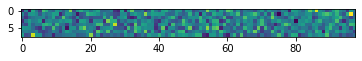

In [10]:
with nengo_dl.Simulator(
        net, minibatch_size=100, unroll_simulation=16) as sim:
        sim.freeze_params(net)

        minibatch_size = 100
        output = sim.predict(test_images[:minibatch_size]) # runs sim.predict on the first minibatch of the data 
        plt.figure()
        plt.imshow(output[p][0].reshape(8, -1))


(784, 1)


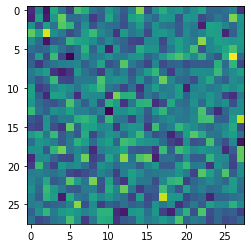

In [15]:

plt.figure()
plt.imshow(output[p][0].reshape(28,28))
# plt.imshow(train_images[0].reshape(28,28))
